In [1]:
# Recommendation: `conda install --channel conda-forge geopandas`
import numpy as np
import math
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import shapely
import json
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from tqdm import tqdm
import os
import folium
import branca.colormap as cm

import scorers
import redistricting
import matplotlib.ticker as ticker

In [2]:
def splits_to_regions_binary(row, splits):
    if splits is None:
        return 0
    if len(splits) == 0:
        return 0

    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num

def count_disjoints(geometry):
    if type(geometry) == Polygon:
        return 1 
    else:
        return len(geometry.geoms)

In [3]:
data_path = "../data/mggg-states/"
output_dir = "../output/"
run_name = "new_2020"

state = "WI"
DEGREE_LIMIT = 0
# scorers 

voting_precincts = gpd.read_file("data_prep/output/wi_2020")
n_districts = 8
pop = "POP20"
d_votes = "USH20_D" # "USH16D" #row["dem_votes"]
r_votes = "USH20_R" #row["rep_votes"]
voting_precincts.sample(n=1)

voting_precincts[d_votes] = voting_precincts[d_votes].fillna(0)
voting_precincts[r_votes] = voting_precincts[r_votes].fillna(0)
voting_precincts[pop] = voting_precincts[pop].fillna(0)

<Axes: >

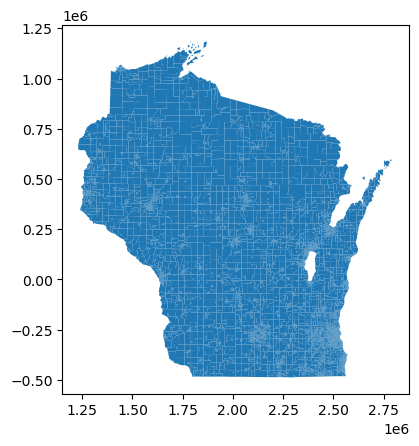

In [4]:
voting_precincts.plot()

In [5]:
voting_precincts['REPRESENTATIVE_POINT'] =  voting_precincts.centroid # voting_precincts.representative_point() https://gis.stackexchange.com/a/414263
voting_precincts['RP_LON'] = voting_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.x)
voting_precincts['RP_LAT'] = voting_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.y)

In [6]:
orig_voting = voting_precincts[[d_votes, r_votes]].sum()/(voting_precincts[[d_votes, r_votes]].sum().sum())
orig_voting

USH20_D    0.485246
USH20_R    0.514754
dtype: float64

In [7]:
holder = []   
redistricting.split_this(df=voting_precincts, n_districts=n_districts, pop_col=pop, dem_col=d_votes, rep_col=r_votes, orig_dem=orig_voting[d_votes], orig_rep=orig_voting[r_votes], degree_limit=DEGREE_LIMIT, score_fn=scorers.abs_diff_parta_fn, holder=holder)

100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [00:04<00:00, 78.30it/s]


In [8]:
all_districts = pd.concat(holder).reset_index(drop=True)
split_columns = [c for c in all_districts.columns if c.startswith("SPLIT_")]

for c in split_columns:
    all_districts[c] = all_districts[c].fillna(0)

all_districts['DISTRICT'] = all_districts.apply(splits_to_regions_binary, splits=split_columns, axis=1)

In [9]:
# Shuffle for coloring
n_districts = all_districts['DISTRICT'].nunique()
random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
shuffle_dict = dict(zip(all_districts["DISTRICT"].unique(), random_districts))
all_districts["SHUFFLED"] = all_districts["DISTRICT"].apply(lambda x: shuffle_dict[x])

In [10]:
print(all_districts.groupby("SHUFFLED").sum()[pop].sum())
pop_summary = all_districts.groupby("SHUFFLED").sum()[pop].reset_index()
pop_summary['pct_deviation'] = (pop_summary[pop] - (pop_summary[pop].sum()/n_districts))/(pop_summary[pop].sum()/n_districts)*100
pop_summary

5893718.0


C:\Users\yagne\AppData\Local\Temp\ipykernel_23420\946127779.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(all_districts.groupby("SHUFFLED").sum()[pop].sum())
C:\Users\yagne\AppData\Local\Temp\ipykernel_23420\946127779.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pop_summary = all_districts.groupby("SHUFFLED").sum()[pop].reset_index()


,SHUFFLED,POP20,pct_deviation
0,0.0,737378.0,0.090028
1,1.0,738835.0,0.287798
2,2.0,736441.0,-0.037158
3,3.0,736032.0,-0.092675
4,4.0,738646.0,0.262144
5,5.0,733717.0,-0.406908
6,6.0,737285.0,0.077404
7,7.0,735384.0,-0.180633


<Axes: >

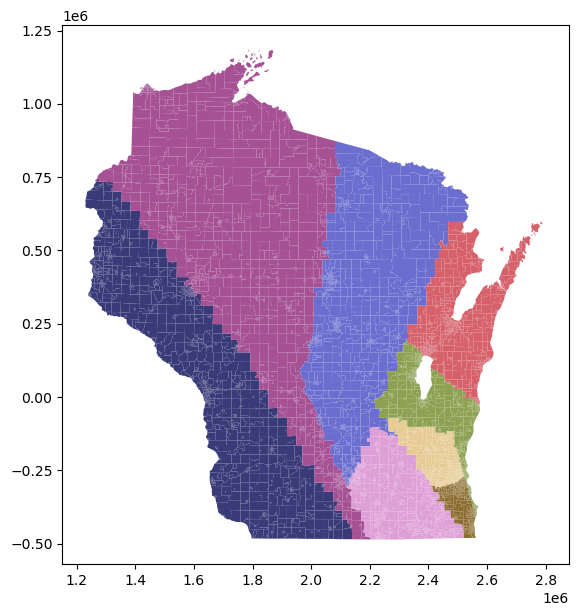

In [11]:
# districts_df = all_districts.dissolve(by="SHUFFLED")
fig, ax = plt.subplots(1,1, figsize=(7,7))
all_districts.plot(ax=ax,cmap="tab20b",column="SHUFFLED",linewidth=0,markersize=0,categorical=True)


In [13]:
all_districts[['geometry', pop, r_votes, d_votes, 'DISTRICT', 'SHUFFLED'] + split_columns].to_file(os.path.join(output_dir, state, f"{state}_{run_name}.shp"))

In [ ]:
# voting_share = voting_precincts.groupby('CONG_DIST')[['USH20_D','USH20_R']].sum().reset_index()
# voting_share["Dem_Ratio"] = round(voting_share["USH20_D"]/(voting_share["USH20_R"]+voting_share["USH20_D"]),2)
# voting_share

In [ ]:
voting_share = all_districts.groupby('SHUFFLED')[['USH20_D','USH20_R']].sum().reset_index()
voting_share["Dem_Ratio"] = round(voting_share["USH20_D"]/(voting_share["USH20_R"]+voting_share["USH20_D"]),2)
voting_share.sort_values(by="Dem_Ratio").reset_index()

In [ ]:
for i in range(len(split_columns)+1):
    redistricting.split_review(
        input_df=all_districts,
        split=i,
        split_cols=split_columns,
        d_votes='USH20_D', 
        r_votes='USH20_R', 
        pop=pop, 
        plot_party=True, 
        figsize=(6,4), 
        save=os.path.join(output_dir, state,f"{state}_{run_name}_{i+1}.png")
)


## Folium Mapping (Interactive), WIP

In [16]:
projected = all_districts.to_crs("EPSG:4326")
projected = projected[['POP20', 'USH20_D','USH20_R','geometry']+split_columns]
projected['REPRESENTATIVE_POINT'] =  projected.centroid
projected['RP_LON'] = projected['REPRESENTATIVE_POINT'].apply(lambda p: p.x)
projected['RP_LAT'] = projected['REPRESENTATIVE_POINT'].apply(lambda p: p.y)

C:\Users\yagne\AppData\Local\Temp\ipykernel_28860\2458600994.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  projected['REPRESENTATIVE_POINT'] =  projected.centroid


In [17]:
split_columns

['SPLIT_1', 'SPLIT_2', 'SPLIT_3']

In [18]:
pop_center_LON = (projected["RP_LON"] * projected['POP20']).sum() / projected['POP20'].sum()
pop_center_LAT = (projected["RP_LAT"] * projected['POP20']).sum() / projected['POP20'].sum()
pre_split = projected.dissolve(aggfunc="sum")
pre_split['id'] = pre_split.index
pre_split['Dem_Ratio'] = round(pre_split['USH20_D']/(pre_split['USH20_D']+pre_split['USH20_R']),4)*100

projected["TEMP_DISTRICT"] = projected.apply(
        redistricting.splits_to_regions_binary, splits=split_columns[:1], axis=1
    )
split_1 = projected.dissolve(aggfunc="sum", by="TEMP_DISTRICT").reset_index()
split_1['id'] = split_1.index
split_1['Dem_Ratio'] = round(split_1['USH20_D']/(split_1['USH20_D']+split_1['USH20_R']),4)*100

projected["TEMP_DISTRICT"] = projected.apply(
        redistricting.splits_to_regions_binary, splits=split_columns[:2], axis=1
    )
split_2 = projected.dissolve(aggfunc="sum", by="TEMP_DISTRICT").reset_index()
split_2['id'] = split_2.index
split_2['Dem_Ratio'] = round(split_2['USH20_D']/(split_2['USH20_D']+split_2['USH20_R']),4)*100

projected["TEMP_DISTRICT"] = projected.apply(
        redistricting.splits_to_regions_binary, splits=split_columns[:3], axis=1
    )
split_3 = projected.dissolve(aggfunc="sum", by="TEMP_DISTRICT").reset_index()
split_3['id'] = split_3.index
split_3['Dem_Ratio'] = round(split_3['USH20_D']/(split_3['USH20_D']+split_3['USH20_R']),4)*100

orig_centroid = pre_split.centroid

C:\Users\yagne\anaconda3\envs\common2\lib\site-packages\geopandas\geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)
C:\Users\yagne\anaconda3\envs\common2\lib\site-packages\geopandas\geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)
C:\Users\yagne\anaconda3\envs\common2\lib\site-packages\geopandas\geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default t

In [19]:
pre_split

,geometry,POP20,USH20_D,USH20_R,SPLIT_1,SPLIT_2,SPLIT_3,RP_LON,RP_LAT,id,Dem_Ratio
0,"MULTIPOLYGON (((-92.38598 44.55781, -92.38905 ...",5893718.0,1566161.0,1661399.0,4354,3631,3623,-633365.016547,311476.385669,0,48.52


In [51]:
# m = folium.Map(location=[orig_centroid[0].y, orig_centroid[0].x], zoom_start=9, tiles="CartoDB positron")
# scale = [30.0, 45.0, 47.5, 50.0, 52.5, 55.0, 70.0]

# folium.Choropleth(
#     geo_data=pre_split,
#     name="Pre-Split",
#     data=pre_split,
#     columns=["id", "Dem_Ratio"],
#     key_on="feature.properties.id",
#     fill_color="RdBu",
#     fill_opacity=0.4,
#     line_opacity=0.5,
#     threshold_scale=scale,
#     legend_name="Democrat Voting Percentage (%)",
# ).add_to(m)

# tooltip = "Population Center"


# folium.Choropleth(
#     geo_data=split_1,
#     name="Split 1",
#     data=split_1,
#     columns=["id", "Dem_Ratio"],
#     key_on="feature.properties.id",
#     fill_color="RdBu",
#     fill_opacity=0.4,
#     line_opacity=0.5,
#     threshold_scale=scale,
#     legend_name="Democrat Voting Percentage (%)",
# ).add_to(m)

# folium.Choropleth(
#     geo_data=split_2,
#     name="Split 2",
#     data=split_2,
#     columns=["id", "Dem_Ratio"],
#     key_on="feature.properties.id",
#     fill_color="RdBu",
#     fill_opacity=0.4,
#     line_opacity=0.5,
#     threshold_scale=scale,
#     legend_name="Democrat Voting Percentage (%)",
# ).add_to(m)


# folium.Choropleth(
#     geo_data=split_3,
#     name="Split 3",
#     data=split_3,
#     columns=["id", "Dem_Ratio"],
#     key_on="feature.properties.id",
#     fill_color="RdBu",
#     fill_opacity=0.4,
#     line_opacity=0.5,
#     threshold_scale=scale,
#     legend_name="Democrat Voting Percentage (%)",
# ).add_to(m)



# folium.LayerControl().add_to(m)

# m

In [21]:
# pop_center_LON = (projected["RP_LON"] * projected['POP20']).sum() / projected['POP20'].sum()
# pop_center_LAT = (projected["RP_LAT"] * projected['POP20']).sum() / projected['POP20'].sum()


In [22]:
split_1

,TEMP_DISTRICT,geometry,POP20,USH20_D,USH20_R,SPLIT_1,SPLIT_2,SPLIT_3,RP_LON,RP_LAT,id,Dem_Ratio
0,0,"MULTIPOLYGON (((-88.54729 43.28315, -88.54861 ...",2944836.0,741863.0,836744.0,0,1205,1401,-241041.702102,119265.614367,0,46.99
1,1,"MULTIPOLYGON (((-92.49816 44.56727, -92.49998 ...",2948882.0,824298.0,824655.0,4354,2426,2222,-392323.314445,192210.771302,1,49.99


In [23]:
folium.Choropleth(
    geo_data=pre_split,
    name="Pre-Split",
    data=pre_split,
    columns=["id", "Dem_Ratio"],
    key_on="feature.properties.id",
    fill_color="RdBu",
    fill_opacity=0.4,
    line_opacity=0.5,
    threshold_scale=scale,
    legend_name="Democrat Voting Percentage (%)",
).add_to(m)


In [24]:
# colormap = cm.StepColormap(["blue", "yellow", "red"], index=[1, 10, 15], vmin=1, vmax=100,tick_labels=[30, 80, 150])
# colormap.add_to(m)
# m